## Generate Data using SAMMY

This notebook works to couple the (recently) open source SAMMY code from ORNL to calculate a RRR cross section. The advantage of coupling to SAMMY is its ability to efficiently apply experimental corrections.

In [2]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
# import nuctools

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.sammy_interface import sammy_interface

In [3]:
%matplotlib widget

In [4]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


In [75]:
### calc calculate a full energy grid yourself 
energy_grid = [2500, 3000]

### or just give the min/max and the experiment object will do the above
# energy_grid = E_min_max

input_options = {'Add Noise': True,
            'Calculate Covariance': True,
            'Sample TURP': False}

experiment_parameters = {'bw': {'val':0.01,    'unc'   :   0},
                         'trigo': {'val':1e9,    'unc'   :   0},
                         'trigs': {'val':1e9,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)

444

In [44]:
spin_groups = [ (3.0,1,0) ]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':28.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':640.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':460.4, '4.0':35.5}  })
                                    
                                    
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

resonance_ladder

,E,Gg,gnx2,J,chs,lwave,J_ID
0,2500.157671,709.938057,53.757073,3.0,1.0,0.0,1.0
1,2506.813174,628.601989,67.222101,3.0,1.0,0.0,1.0
2,2532.767887,646.699738,17.448558,3.0,1.0,0.0,1.0
3,2567.209936,681.319064,1464.758371,3.0,1.0,0.0,1.0
4,2601.742138,586.484161,62.668298,3.0,1.0,0.0,1.0
5,2648.922921,655.116383,414.764527,3.0,1.0,0.0,1.0
6,2685.082056,617.172506,291.588941,3.0,1.0,0.0,1.0
7,2700.951256,651.651547,251.471712,3.0,1.0,0.0,1.0
8,2745.598438,615.052002,769.590233,3.0,1.0,0.0,1.0
9,2761.892288,595.030261,1.254671,3.0,1.0,0.0,1.0


In [112]:
resonance_ladder.to_csv('./UPR_presentation_ladder.csv')

### Calculate cross section using SAMMY and run experiment

In [76]:
theo = sammy_interface.calculate_xs(exp.energy_domain, resonance_ladder, Ta_pair,
                                            model = 'XCT',
                                            expertimental_corrections = 'all_exp',
                                            sammy_runDIR = 'SAMMY_runDIR',
                                            keep_runDIR=True,
                                            one_spingroup = False    
                                            )
exp.run(theo)
# exp.redpar - exp.theo_redpar

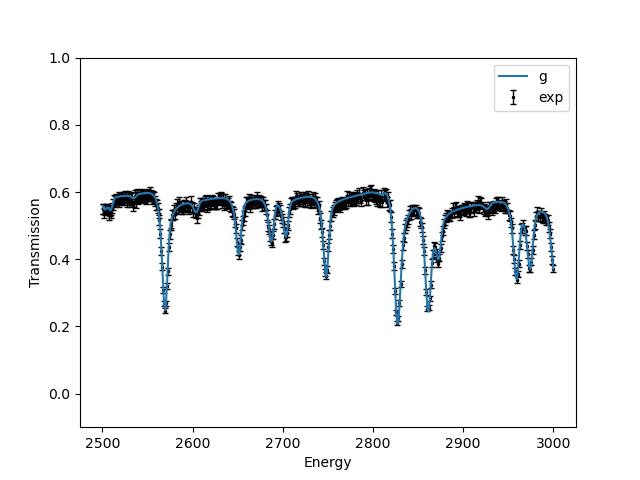

In [77]:
figure()
plot(theo.E, theo.theo_trans, ms=1, label='g')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

In [78]:
from ATARI.utils.datacontainer import DataContainer
d = DataContainer()
d.add_theoretical(Ta_pair, resonance_ladder)
d.add_experimental(exp)
d.fill()

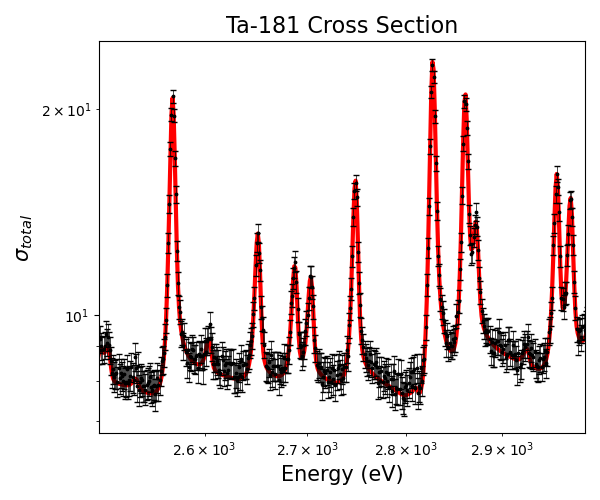

In [111]:
figure(figsize=(6,5))

errorbar(d.pw_exp.E, d.pw_exp.exp_xs, yerr=d.pw_exp.exp_xs_unc, zorder=2,
                                fmt='.', color='k', ecolor='k', linewidth=0.5, markersize=3.5, capsize=2, label='exp')


plot(theo.E, theo.theo_xs, color='r', zorder=0, lw=3)

xlim([2501,2990])
yscale('log')
xscale('log')
ylabel(r'$\sigma_{total}$', fontsize=15)
xlabel('Energy (eV)', fontsize=15)
title('Ta-181 Cross Section', fontsize=16)

tight_layout()